In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import pandas as pd

# Read Data Set

In [2]:
df = pd.read_csv("data/EEG_Eye_State.arff",comment="@",header = None)

+ Extract the label

In [3]:
y = df[df.columns[-1]]
del df[df.columns[-1]]

+ filter outliers

In [4]:
highest_quantile = np.percentile(df,99,axis=0)
df[df > highest_quantile] = np.nan
df = df.fillna(df.quantile(0.99))

In [5]:
lowest_quantile = np.percentile(df,1,axis=0)
df[df < lowest_quantile] = np.nan
df = df.fillna(df.quantile(0.01))

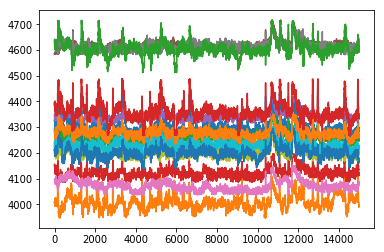

In [6]:
_ = plt.plot(df)

Standardize using a z-score: 

$$z_{i,d} = \frac{x_{i,d} - \mu_d}{\sigma_d}$$

+ $\mu_d$ : mean along dimension $d$
+ $\sigma_d$ : std along dimension $d$
+ $x_{i,d}$ : $i$-th coordinate along dimension $d$

In [7]:
df = (df - df.mean()) * 1./(df.std()+0.00001)

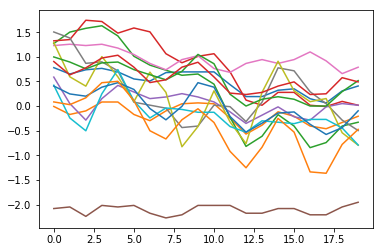

In [8]:
_ = plt.plot(df.values[:20,:])

array([ 0.57283201,  0.7255303 ,  0.83945576,  0.87465887,  0.90188819,
        0.92376058,  0.93942966,  0.95297484,  0.96519949,  0.97588912,
        0.98430863,  0.9919202 ,  0.99777014,  1.        ])

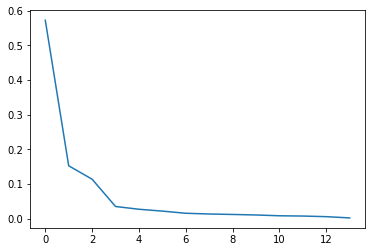

In [9]:
from sklearn import decomposition
pca = decomposition.PCA(df.shape[1])
pca.fit(df)
df = pd.DataFrame(pca.transform(df)[:,:4])
#plt.plot(X_pc)
plt.plot(pca.explained_variance_ratio_)
np.cumsum(pca.explained_variance_ratio_)

# Seq2Seq

In [164]:
import seq2seq
from seq2seq.models import Seq2Seq
from keras.callbacks import ModelCheckpoint
batch_size = 32
timesteps = 15
latent_dim = 5
depth = 2
jump = 3
input_dim = df.shape[1]
sequence_autoencoder =  Seq2Seq(input_shape=(timesteps, input_dim),
                                hidden_dim=latent_dim,
                                output_length=timesteps,
                                output_dim=input_dim,
                                depth=depth,
                                peek=True,
                                broadcast_state = True,
                                dropout = 0.2
                                )
sequence_autoencoder.compile(loss='mse', optimizer='rmsprop')

# Fit

In [165]:
indexes = [range(i,i+timesteps) for i in range(0,df.shape[0]-jump-timesteps,jump)]
X = df.values[indexes]

In [166]:
nb_epoch = 30
validation_split = 0.1
filepath_loss = "checkpoint/better_loss_.hdf5"
checkpoint_loss = ModelCheckpoint(filepath_loss,
                                  monitor='loss',
                                  verbose=0,
                                  save_best_only=True,
                                  mode='auto')
filepath_val_loss = "checkpoint/better_val_loss_epoch-{epoch:02d}.hdf5"   
checkpoint_val_loss = ModelCheckpoint(filepath_val_loss,
                                      monitor='val_loss',
                                      verbose=0,
                                      save_best_only=True,
                                      mode='auto')
callbacks_list = [checkpoint_loss,
                  checkpoint_val_loss]
history = sequence_autoencoder.fit(X,
                                   X,
                                   batch_size,
                                   nb_epoch,
                                   callbacks = callbacks_list,
                                   validation_split=validation_split,
                                   verbose = 1,
                                   shuffle = True)

Train on 4489 samples, validate on 499 samples
Epoch 1/30
4489/4489 [==============================] - 32s - loss: 3.0701 - val_loss: 1.9745
Epoch 2/30
4489/4489 [==============================] - 21s - loss: 2.6393 - val_loss: 1.7192
Epoch 3/30
4489/4489 [==============================] - 21s - loss: 2.5138 - val_loss: 1.6994
Epoch 4/30
4489/4489 [==============================] - 21s - loss: 2.4681 - val_loss: 1.6897
Epoch 5/30
4489/4489 [==============================] - 20s - loss: 2.4471 - val_loss: 1.6891
Epoch 6/30
4489/4489 [==============================] - 20s - loss: 2.4319 - val_loss: 1.6658
Epoch 7/30
4489/4489 [==============================] - 20s - loss: 2.4140 - val_loss: 1.6447
Epoch 8/30
4489/4489 [==============================] - 21s - loss: 2.3952 - val_loss: 1.5771
Epoch 9/30
4489/4489 [==============================] - 20s - loss: 2.3813 - val_loss: 1.5550
Epoch 10/30
4489/4489 [==============================] - 21s - loss: 2.3740 - val_loss: 1.5356
Epoch 11/30


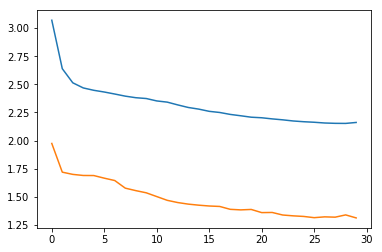

In [167]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Define the encoder

In [168]:
from keras import backend as K

In [174]:
inputs = Input(shape=(timesteps, input_dim))
td = sequence_autoencoder.get_layer(index=1)(inputs)
seq_vec = sequence_autoencoder.encoder(td)
encoder = Model(inputs, seq_vec[-1])


batch_size = 32
timesteps = 15
latent_dim = 5

# Encode

In [177]:
x_test_encoded = encoder.predict(X)

## Apply TSNE

In [178]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(x_test_encoded)

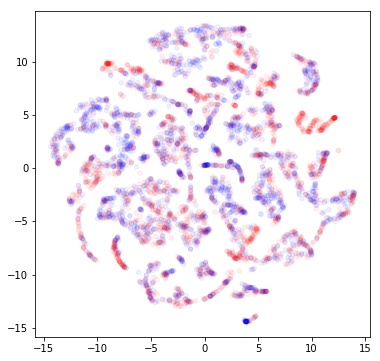

In [179]:
colors_map = {1:"red", 0:"blue"}
plt.figure(figsize=(6, 6))
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=map(colors_map.__getitem__,y), alpha = 0.06,s=20)

'\nplt.figure()\nplt.scatter(x_test_pca[2], x_test_pca[1], c=map(colors_map.__getitem__,y), alpha = 0.003,s=50)\n'

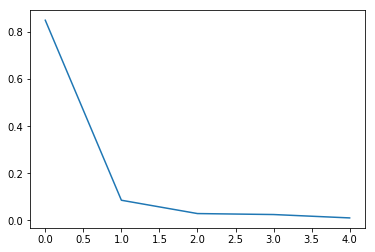

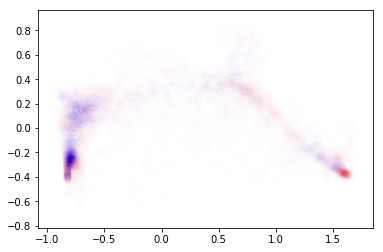

In [183]:
from sklearn import decomposition
pca = decomposition.PCA(x_test_encoded.shape[1])
pca.fit(x_test_encoded)
x_test_pca = pd.DataFrame(pca.transform(x_test_encoded))
#plt.plot(X_pc)
plt.plot(pca.explained_variance_ratio_)
np.cumsum(pca.explained_variance_ratio_)
plt.figure()

plt.scatter(x_test_pca[0], x_test_pca[1], c=map(colors_map.__getitem__,y), alpha = 0.003,s=50)


# Generate

In [192]:
seq_dec

<tf.Tensor 'recurrent_sequential_41_1/cond_1/Merge:0' shape=(?, ?, 4) dtype=float32>

In [193]:
batch_size = 32
timesteps = 15
latent_dim = 5
depth = 2
jump = 3
input_dim = df.shape[1]

inputs_generator = Input(shape=(latent_dim, ))
hidden_generator = sequence_autoencoder.layers[-2](inputs_generator)
seq_dec = sequence_autoencoder.decoder(hidden_generator)
decoder = Model(inputs_generator, seq_dec)

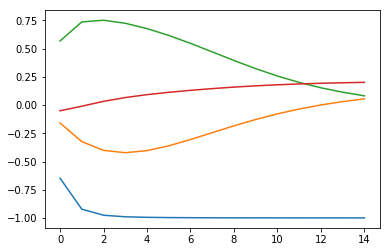

In [228]:
a = decoder.predict(np.array([-0.04,-3.05,-0.02,3,-3.9]).reshape(1,5))
plt.plot(a.reshape(15,4))